In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

from sklearn.model_selection import train_test_split



In [ ]:
import glob
import os
import math
import operator
import functools
import random
import datetime
from scipy.ndimage.interpolation import rotate, shift, zoom

In [5]:
from google.colab import files
uploaded = files.upload()

Saving X.npy to X.npy


In [6]:
from google.colab import files
uploaded = files.upload()

Saving Y.npy to Y.npy


In [9]:
all_X = np.load('X.npy')
all_Y = np.load('Y.npy')

In [10]:
test_size = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(all_X, all_Y, test_size=test_size, random_state=42)


In [11]:
print("Training Shape: ", X_train.shape)
print(X_train.shape[0], 'sample', X_train.shape[1], 'x', X_train.shape[2], 'size grayscale image.\n')

print('Test Shape: ', X_test.shape)

print(X_test.shape[0], 'sample,', X_test.shape[1], 'x', X_test.shape[2], 'size grayscale image. \n')


Training Shape:  (1752, 64, 64)
1752 sample 64 x 64 size grayscale image.

Test Shape:  (310, 64, 64)
310 sample, 64 x 64 size grayscale image. 



In [12]:
Y_test_cls = np.argmax(Y_test, axis=1)
Y_train_cls = np.argmax(Y_train, axis=1)


In [13]:
img_size = 64

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_channels = 1

num_classes = 10



In [14]:
def plot_images(images, cls_true, cls_pred = None):
  assert len(images) == len(cls_true) == 9

  fig, axes = plt.subplots(3, 3)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].reshape(img_shape), cmap='binary')

    if cls_pred is None:
      xlabel = "True: {0}".format(cls_true[i])
    else:
      xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

    ax.set_xlabel(xlabel)

    ax.set_xticks([])
    ax.set_yticks([])

  plt.show()

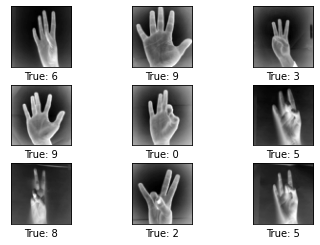

In [15]:
images = X_test[0:9]

cls_true = Y_test_cls[0:9]

plot_images(images=images, cls_true=cls_true)


In [18]:
train_X = X_train
train_Y = Y_train
new_train_X = train_X.reshape(X_train.shape[0], img_size_flat)
new_test_X = X_test.reshape(X_test.shape[0], img_size_flat)


In [19]:
print("Training set (images) shape: {shape}".format(shape=new_train_X.shape))

print("Training set (labels) shape: {shape}".format(shape=train_Y.shape))

print("Test set (images) shape: {shape}".format(shape=new_test_X.shape))

print("Test set (labels) shape: {shape}".format(shape=Y_test.shape))


Training set (images) shape: (1752, 4096)
Training set (labels) shape: (1752, 10)
Test set (images) shape: (310, 4096)
Test set (labels) shape: (310, 10)


### Configuration of Neural Network

In [20]:
learning_rate = 0.001
training_iters = 40000
batch_size = 16
display_step = 20

n_input = img_size_flat
dropout = 0.75

In [21]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [22]:
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)
print('Shape of placeholder', x.shape, y.shape)


Shape of placeholder (?, 4096) (?, 10)


In [23]:
def conv2d(x, W, b, strides=1):
  x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
  x = tf.nn.bias_add(x, b)
  return tf.nn.relu(x)
  

In [24]:
def maxpool2d(x, k=2):
  return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


In [25]:
def conv_net(x, weights, biases, dropout):
  x = tf.reshape(x, shape=[-1, 64, 64, 1])

  conv1 = conv2d(x, weights['wc1'], biases['bc1'])
  conv1 = maxpool2d(conv1, k=2)

  conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
  conv2 = maxpool2d(conv2, k=2)

  fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
  fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
  fc1 = tf.nn.relu(fc1)
  fc1 = tf.nn.dropout(fc1, dropout)

  out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
  return out

  

In [26]:
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]), name='wc1'),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]), name='wc2'),
    'wd1': tf.Variable(tf.random_normal([64 * 64 * 4, 1024]), name='wout'),
    'out': tf.Variable(tf.random_normal([1024, num_classes]), name='wout')
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]), name='bc1'),
    'bc2': tf.Variable(tf.random_normal([64]), name='bc2'),
    'bd1': tf.Variable(tf.random_normal([1024]), name='bd1'),
    'out': tf.Variable(tf.random_normal([num_classes]), name='bout')

}

In [27]:
model = conv_net(x, weights, biases, keep_prob)
print(model)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(cost)

y_true_cls = tf.argmax(y, 1)
y_pred_cls = tf.argmax(model, 1)

correct_model = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_model, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Tensor("Add_1:0", shape=(?, 10), dtype=float32)


In [28]:
def getBatch(X, Y, batchSize=16):
  arrayLength = X.shape[0]
  count = 0

  while count < arrayLength / batchSize:
    random.seed(datetime.datetime.now())
    randstart = random.randint(0, arrayLength-batchSize-1)
    count += 1
    yield (X[randstart:randstart+batchSize], Y[randstart:randstart+batchSize])



In [29]:
loss_t = []
steps_t = []
acc_t = []

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1   
#     Keep training until reach max iterations
    while step * batch_size < training_iters:
        a = getBatch(new_train_X,train_Y, batch_size)
        batch_x, batch_y = next(a)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        if step % display_step == 0:
            print('*'*15)
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Loss= " + \
                  "{:.3f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
            loss_t.append(loss)
            steps_t.append(step*batch_size)
            acc_t.append(acc)
        step += 1
    
   #
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: new_test_X,
                                      y: Y_test,
                                      keep_prob: 1.}))
    
    cls_pred = sess.run(y_pred_cls, feed_dict={x: new_test_X,
                                      y: Y_test,
                                      keep_prob: 1.})

***************
Iter 320, Loss= 144597.453, Training Accuracy= 0.062
***************
Iter 640, Loss= 179295.734, Training Accuracy= 0.062
***************
Iter 960, Loss= 115277.562, Training Accuracy= 0.125
***************
Iter 1280, Loss= 137227.938, Training Accuracy= 0.125
***************
Iter 1600, Loss= 155092.172, Training Accuracy= 0.062
***************
Iter 1920, Loss= 136101.344, Training Accuracy= 0.125
***************
Iter 2240, Loss= 172054.500, Training Accuracy= 0.062
***************
Iter 2560, Loss= 158939.906, Training Accuracy= 0.062
***************
Iter 2880, Loss= 166190.906, Training Accuracy= 0.062
***************
Iter 3200, Loss= 122215.609, Training Accuracy= 0.125
***************
Iter 3520, Loss= 148977.469, Training Accuracy= 0.125
***************
Iter 3840, Loss= 160454.938, Training Accuracy= 0.000
***************
Iter 4160, Loss= 150563.969, Training Accuracy= 0.125
***************
Iter 4480, Loss= 111250.625, Training Accuracy= 0.125
***************
Iter 48

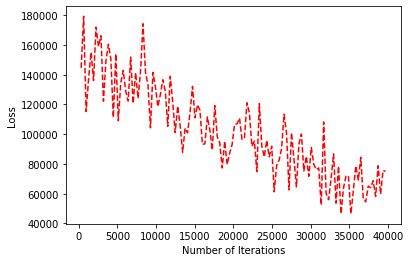

In [31]:
plt.plot(steps_t, loss_t, 'r--')
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

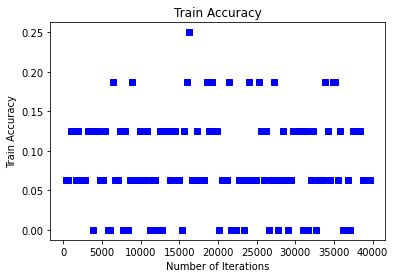

In [32]:
plt.plot(steps_t, acc_t, 'bs')
plt.title("Train Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Train Accuracy")
plt.show()

In [33]:
correct = (Y_test_cls == cls_pred)

correct_sum = correct.sum()
num_test = X_test.shape[0]

acc = float(correct_sum) / num_test
msg = "Accuracy on Test - Set: {0:.1} ({1} / {2})"
print(msg.format(acc, correct_sum, num_test))



Accuracy on Test - Set: 0.1 (37 / 310)


In [34]:
def plot_example_errors(cls_pred, correct):

  incorrect = (correct == False)
  images = new_test_X[incorrect]
  cls_pred = cls_pred[incorrect]
  cls_true = Y_test_cls[incorrect]

  plot_images(images = images[0:9],
              cls_true=cls_true[0:9],
              cls_pred = cls_pred[0:9])
  


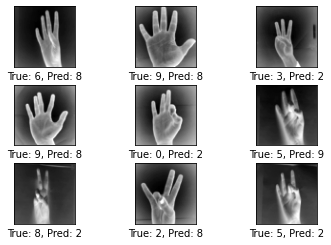

In [35]:
plot_example_errors(cls_pred=cls_pred, correct=correct)

In [36]:
def plot_confusion_matriz(cls_pred):

  cls_true = Y_test_cls
  cm = confusion_matrix(y_true=cls_true,
                        y_pred=cls_pred)
  print(cm)
  plt.matshow(cm)
  plt.colorbar()
  tick_marks = np.arange(num_classes)
  plt.xticks(tick_marks, range(num_classes))
  plt.yticks(tick_marks, range(num_classes))
  plt.xlabel("Predicted ")
  plt.ylabel("True")
  plt.show()


[[ 0  0 21  0  1  0  0  0  1  4]
 [ 0  0 29  0  0  0  0  0  3  0]
 [ 0  0 25  0  0  0  3  3 11  0]
 [ 0  0 17  0  0  0  0  4  7  0]
 [ 0  0 17  0  0  0  1  0  5  1]
 [ 0  0 17  0  0  0  0  3  5  3]
 [ 1  0 20  0  0  0  0  3  6  0]
 [ 0  0 21  0  0  0  0  2  3  4]
 [ 0  0 27  0  0  0  0  1  6  0]
 [ 0  0 21  0  0  0  3  3  4  4]]


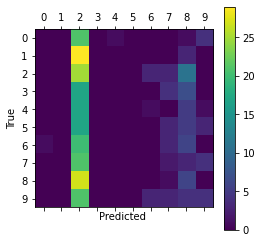

In [37]:
plot_confusion_matriz(cls_pred = cls_pred)
